In [63]:
import os
import pandas as pd
from PIL import Image
import torch
import kagglehub
from sklearn.metrics import accuracy_score

from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



from torch.utils.data import DataLoader
from torchvision import transforms

# EDA

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [65]:
path = kagglehub.dataset_download("alessiocorrado99/animals10")+"\\raw-img"

print("Path to dataset files:", path)

Path to dataset files: C:\Users\matej\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img


Animals type 

In [66]:
clases = os.listdir(path)
print(clases)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


Num of photos in each folder

In [67]:
print(f"{'Class Name':<20} | {'Count'}")
print("-" * 30)
for cl in clases:
    folder_path = os.path.join(path, cl)
    count = len(os.listdir(folder_path))
    print(f"{cl:<20} | {count}")

Class Name           | Count
------------------------------
cane                 | 4863
cavallo              | 2623
elefante             | 1446
farfalla             | 2112
gallina              | 3098
gatto                | 1668
mucca                | 1866
pecora               | 1820
ragno                | 4821
scoiattolo           | 1862


See what we have in dataset

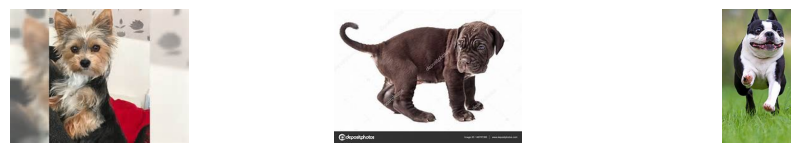

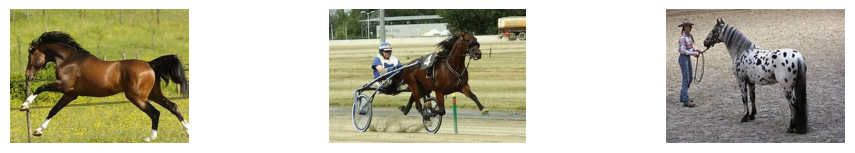

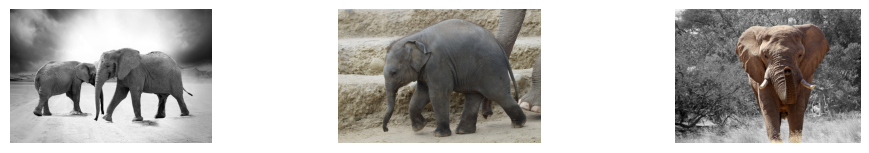

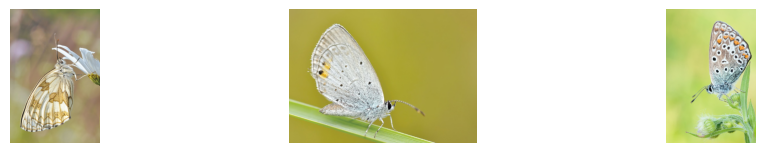

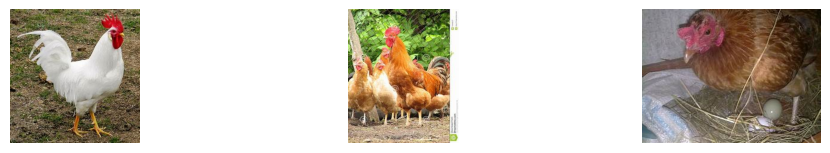

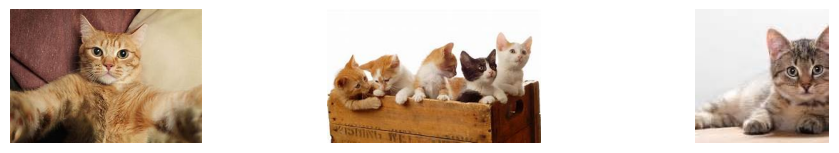

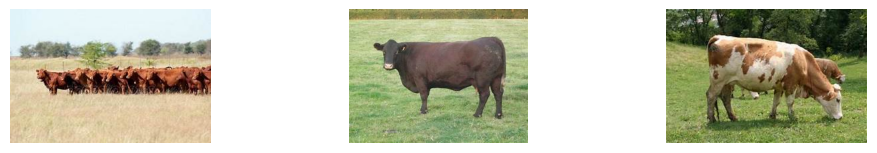

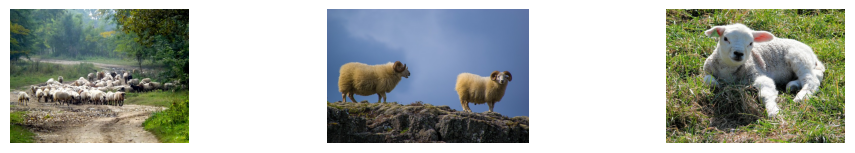

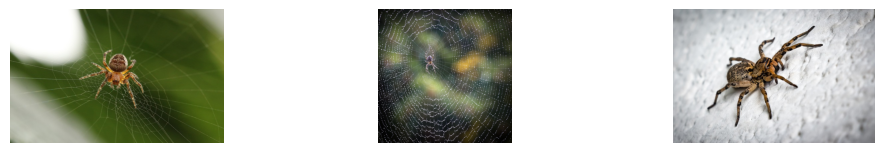

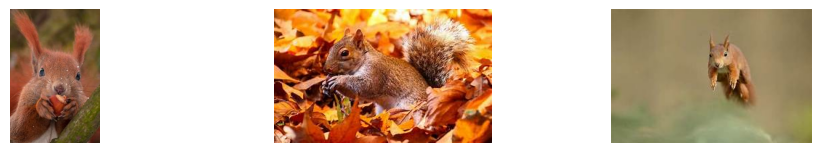

In [68]:
for cl in clases:
    n=3
    plt.figure(figsize=(12, 8))
    a = path+"\\"+cl
    imgs = os.listdir(a)
    i=1
    for _ in range(n):
        img_path = os.path.join(a, imgs[_])
        img = Image.open(img_path)

        plt.subplot(4, n, i)
        plt.imshow(img)
        plt.axis("off")
        i += 1

Analyze avg size

In [69]:
width = ([])
height = ([])
for cl in clases:
    a = path+"\\"+cl
    b = len(os.listdir(a))
    imgs = os.listdir(a)
    for im_name in imgs:
        img_path = os.path.join(a, im_name)
        im = Image.open(img_path)
        h, w = im.size
        width.append(w)
        height.append(h)
    print("\n"+cl)
    print(sum(width)/b)
    print(sum(height)/b)


cane
241.08513263417643
283.568990335184

cavallo
680.4388105223027
813.6820434616851

elefante
1509.216459197787
1853.6175656984785

cavallo
680.4388105223027
813.6820434616851

elefante
1509.216459197787
1853.6175656984785

farfalla
1313.715909090909
1633.6458333333333

farfalla
1313.715909090909
1633.6458333333333

gallina
1134.963847643641
1402.0025823111685

gatto
2472.5575539568345
3077.1157074340526

gallina
1134.963847643641
1402.0025823111685

gatto
2472.5575539568345
3077.1157074340526

mucca
2422.9431939978563
3044.7861736334407

mucca
2422.9431939978563
3044.7861736334407

pecora
2747.5478021978024
3484.7895604395603

pecora
2747.5478021978024
3484.7895604395603

ragno
1285.0680356772455
1626.7031736154324

scoiattolo
3551.8823845327606
4499.6219119226635

ragno
1285.0680356772455
1626.7031736154324

scoiattolo
3551.8823845327606
4499.6219119226635


In [70]:
# Analyze Image Channels
modes = {}
channels_count = {}

print("Analyzing image modes and channels")
for cl in clases:
    folder = os.path.join(path, cl)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            with Image.open(img_path) as img:
                # Count modes (RGB, L, CMYK, etc.)
                modes[img.mode] = modes.get(img.mode, 0) + 1
                # Count channels
                c = len(img.getbands())
                channels_count[c] = channels_count.get(c, 0) + 1
        except:
            pass

print("Image Modes:", modes)
print("Channel Counts:", channels_count)

if 1 in channels_count or 4 in channels_count:
    print("\nNote: Dataset contains images with different channel counts.")
    print("We will convert all images to RGB (3 channels/parameters per pixel) during preprocessing.")
else:
    print("\nAll images are already 3 channels (RGB).")

Analyzing image modes and channels
Image Modes: {'RGB': 26128, 'RGBA': 49, 'L': 1, 'CMYK': 1}
Channel Counts: {3: 26128, 4: 50, 1: 1}

Note: Dataset contains images with different channel counts.
We will convert all images to RGB (3 channels/parameters per pixel) during preprocessing.
Image Modes: {'RGB': 26128, 'RGBA': 49, 'L': 1, 'CMYK': 1}
Channel Counts: {3: 26128, 4: 50, 1: 1}

Note: Dataset contains images with different channel counts.
We will convert all images to RGB (3 channels/parameters per pixel) during preprocessing.


Resize

Smth abit wrong with it

In [71]:
# TARGET_SIZE = (170, 170)
# skipped = 0
# count = 0
# errors = 0

# for cl in clases:
#     folder = os.path.join(path, cl)

#     for img_name in os.listdir(folder):
#         img_path = os.path.join(folder, img_name)

#         try:
#             with Image.open(img_path) as img:
#                 if img.size == TARGET_SIZE:
#                     skipped += 1
#                     continue

#                 img = img.resize(TARGET_SIZE)
#                 img.save(img_path)
#                 count += 1

#         except Exception:
#             errors += 1
#             print("Error opening:", img_path)

#             try:
#                 os.remove(img_path)
#                 print("deleted.")
#             except:
#                 print("cannot delete.")


In [53]:
files = []
labels = []
class_names = sorted(os.listdir(path))

class_to_idx = {c: i for i, c in enumerate(class_names)}

print("Loading dataset...")
for cl in clases:
    a = path+"\\"+cl
    # Verify folder exists
    if not os.path.isdir(a):
        continue
        
    for img in os.listdir(a):
        files.append(os.path.join(a, img))
        labels.append(class_to_idx[cl])

print(f"Total images loaded: {len(files)}")
print(f"Total classes: {len(class_names)}")
print(f"Class mapping: {class_to_idx}")

Loading dataset...
Total images loaded: 26179
Total classes: 10
Class mapping: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}


In [54]:
print("Splitting dataset into Train and Test sets...")
train_files, test_files, train_labels, test_labels = train_test_split(
    files, labels,
    test_size=0.2,
    stratify=labels,
    shuffle=True,
    random_state=42
)

print(f"Training samples: {len(train_files)}")
print(f"Testing samples: {len(test_files)}")

Splitting dataset into Train and Test sets...
Training samples: 20943
Testing samples: 5236


In [55]:
#Budeme vyuzivat accuracy a f1

In [ ]:
# Define training transformations with augmentation
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")), # Ensure 3 channels (R, G, B)
    transforms.Resize((170, 170)),                 # Resize to consistent size
    transforms.RandomHorizontalFlip(p=0.25),        # Data Augmentation: Flip
    transforms.RandomRotation(5),                  # Data Augmentation: Rotate
    transforms.ColorJitter(                        # Data Augmentation: Color
        brightness=0.15,
        contrast=0.15
    ),
    transforms.ToTensor(),                         # Convert to Tensor (0-1 range)
    transforms.Normalize(                          # Normalize to range [-1, 1]
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
print("Training transforms defined.")

Training transforms defined.


Visualizing Training Augmentations:


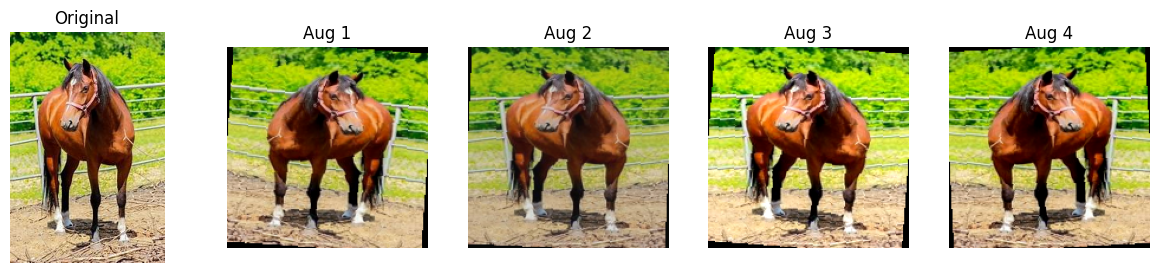

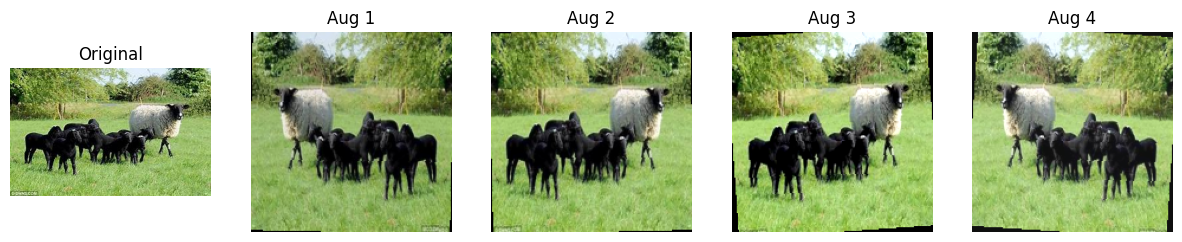

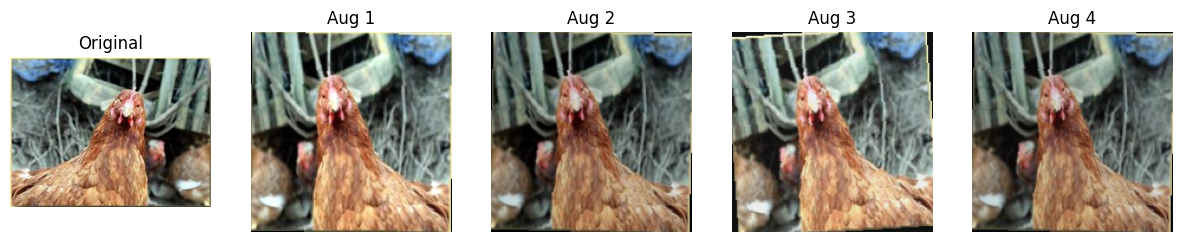

In [ ]:
# Visualization of Augmentations
import numpy as np
import random

def visualize_augmentations(files, transform, n_samples=3):
    """
    Visualizes original images and their augmented versions.
    """
    # Select random files
    sample_files = random.sample(files, n_samples)
    
    for img_path in sample_files:
        # Load original
        original_img = Image.open(img_path)
        
        # Apply transform multiple times to see variations
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        
        # Show original
        axes[0].imshow(original_img)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        for i in range(1, 5):
            # Apply transform
            aug_tensor = transform(original_img)
            
            # Un-normalize and convert to numpy for display
            # Using simple 0.5 mean/std
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            
            aug_img = aug_tensor.permute(1, 2, 0).numpy()
            aug_img = std * aug_img + mean
            aug_img = np.clip(aug_img, 0, 1)
            
            axes[i].imshow(aug_img)
            axes[i].set_title(f"Aug {i}")
            axes[i].axis('off')
        plt.show()

print("Visualizing Training Augmentations:")
visualize_augmentations(train_files, train_transform)

In [ ]:
# Define test transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")), # Ensure 3 channels
    transforms.Resize((170, 170)),                 # Resize to consistent size
    transforms.ToTensor(),                         # Convert to Tensor
    transforms.Normalize(                          # Normalize to range [-1, 1]
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
print("Test transforms defined.")

Test transforms defined.


In [59]:
class AnimalDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.labels[idx]

# Initialize Datasets
print("Initializing Datasets...")
train_dataset = AnimalDataset(train_files, train_labels, transform=train_transform)
test_dataset = AnimalDataset(test_files, test_labels, transform=test_transform)

# Initialize DataLoaders
BATCH_SIZE = 32
print(f"Initializing DataLoaders with batch size {BATCH_SIZE}...")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Data preparation complete.")

Initializing Datasets...
Initializing DataLoaders with batch size 32...
Data preparation complete.


Visualizing samples from Test Dataset (Preprocessed)...


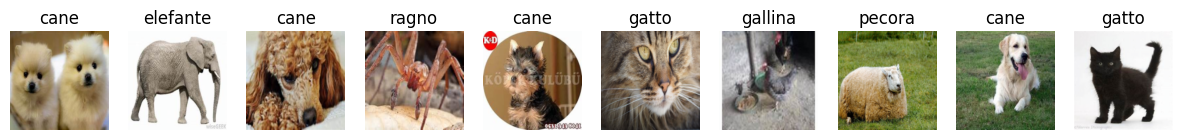

In [ ]:
# Visualize Test Data
print("Visualizing samples from Test Dataset (Preprocessed)...")

def visualize_dataset_samples(dataset, class_names, n_samples=5):
    indices = random.sample(range(len(dataset)), n_samples)
    
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Denormalize for visualization
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        
        img_display = image.permute(1, 2, 0).numpy()
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)
        
        axes[i].imshow(img_display)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    
    plt.show()

visualize_dataset_samples(test_dataset, class_names, 10)